In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

data = pd.read_excel('/Users/matiasgonzalez/Desktop/Backtesting /bbdd seleccion portafolio.xlsx', index_col=0, parse_dates=True)
data = data.sort_index(ascending=True)
nombres = {'SPX Index': 'USA', 'MXEUG Index': 'Europa equities', 'UKX Index': 'UK', 'MXJP Index': 'Japon', 'MXAPJ Index': 'Asia',
            'MXLA Index': 'Latam', 'LF98TRUU Index': 'US HY', 'LUACTRUU Index': 'US IG', 'LBEATRUH Index': 'Europa bonds', 'BSELTRUU Index': 'Latam corp',
              'BSSUTRUU Index': 'Emerging sov', 'CABS Index': 'ABS', 'BCOMTR Index': 'Commodities', 'GLD US EQUITY': 'Oro', 'MXWD Index': 'World equities',}
data = data.rename(columns=nombres)
data

,USA,Europa equities,UK,Japon,Asia,Latam,US HY,US IG,Europa bonds,Latam corp,Emerging sov,ABS,Commodities,Oro,World equities
Dates,,,,,,,,,,,,,,,
2009-12-20,1104.0608,134.7947,8376.2673,6.1667,397.9240,3976.9720,1044.25,1905.70,189.55,555.2780,210.5655,150.639,271.8540,108.95,297.4064
2009-12-21,1115.6747,136.6045,8517.0090,6.1270,395.1220,3964.6336,1044.88,1893.96,189.14,554.5421,210.4116,150.407,270.7502,106.95,299.9065
2009-12-22,1119.6683,137.3385,8523.7259,6.1664,398.5079,4004.6886,1046.41,1889.69,188.91,555.3576,210.5412,150.258,270.5780,106.17,301.0280
2009-12-23,1122.4861,138.4527,8588.8493,6.1866,402.9362,4043.5493,1047.55,1891.02,188.62,555.1265,210.4938,150.368,275.4902,106.55,303.0812
2009-12-24,1128.3889,138.4434,8624.4220,6.2528,407.3329,4069.3275,1047.69,1883.73,188.63,554.6907,210.4230,150.244,276.9486,108.36,304.7853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-19,5993.7779,245.5818,11875.9472,11.6785,623.9013,2296.5618,2771.98,3385.50,311.54,1183.6470,422.2970,249.345,264.6555,310.26,1307.3138
2025-06-20,5981.0584,247.8573,11893.3939,11.5758,630.1330,2281.6601,2776.14,3387.72,311.59,1183.9853,421.8314,249.492,263.1584,310.13,1307.1972
2025-06-21,5981.0584,247.8573,11893.3939,11.5758,630.1330,2281.6601,2776.14,3387.72,311.59,1183.9853,421.8314,249.492,263.1584,310.13,1307.1972


<Figure size 1200x600 with 0 Axes>

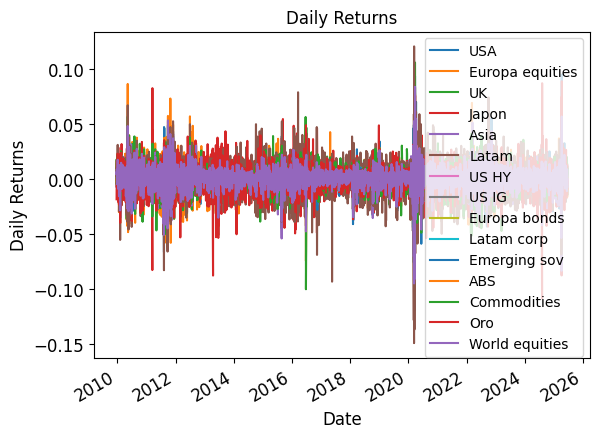

In [97]:
# Compute daily returns and drop rows with missing values
returns = data.pct_change().dropna(how="all")
#Eliminar valores cero
returns = returns[~(returns == 0).any(axis=1)]
plt.figure(figsize=(12, 6))
returns.plot(title="Daily Returns", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Returns", fontsize=12)
plt.legend(returns.columns, fontsize=10)
plt.show()
returns.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornosdf.xlsx', index=True)

<Figure size 1000x800 with 0 Axes>

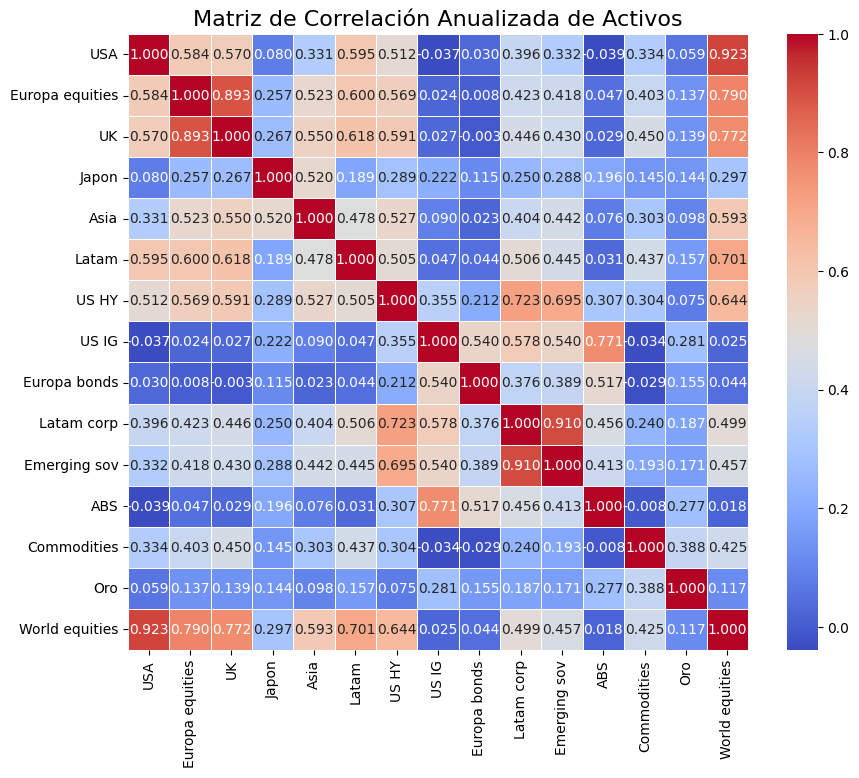

In [45]:
corr_matrix = returns.corr()  # Correlation matrix
plt.figure(figsize=(10, 8)) # Ajusta el tamaño del gráfico

plt.figure(figsize=(10, 8)) # Ajusta el tamaño del gráfico

sns.heatmap(
    corr_matrix,
    annot=True,          # Muestra los valores numéricos en cada celda
    fmt=".3f",           # Formato de los números (3 decimales)
    cmap='coolwarm',     # Paleta de colores (cálido para positivo, frío para negativo)
    linewidths=.5        # Líneas para separar las celdas
)

plt.title('Matriz de Correlación Anualizada de Activos', fontsize=16)
plt.show()



In [46]:
#Equal weight strategy
def backtest_benchmark(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    weights = [.35, .6, .05]  # Weights for USA, US IG, and Oro
    #n_assets = 3
    #weights = np.array([1/n_assets] * n_assets)
    activos = ['World equities', 'US IG', 'Oro']
    returns = returns[activos]

    for date in returns.index[lookback:]:
        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]) 

benchmark_results = backtest_benchmark(returns)
print(benchmark_results)
retorno_acum_benchmark = (1+benchmark_results).cumprod()
print(retorno_acum_benchmark)





Dates
2015-06-10    0.002783
2015-06-11    0.004072
2015-06-12   -0.001851
2015-06-15   -0.002025
2015-06-16    0.001849
                ...   
2025-06-13   -0.005761
2025-06-16    0.001488
2025-06-17   -0.000669
2025-06-18   -0.000385
2025-06-20    0.000341
Length: 2298, dtype: float64
Dates
2015-06-10    1.002783
2015-06-11    1.006867
2015-06-12    1.005003
2015-06-15    1.002968
2015-06-16    1.004822
                ...   
2025-06-13    1.796809
2025-06-16    1.799483
2025-06-17    1.798278
2025-06-18    1.797586
2025-06-20    1.798200
Length: 2298, dtype: float64


In [47]:
# Calculate the covariance matrix
def port_var(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#Calculate the risk contribution of each asset
def calculate_risk_contribution(weights, cov_matrix):
    portfolio_variance = port_var(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = np.multiply(weights, marginal_contrib) / portfolio_variance
    return risk_contrib

#Crear la función objetivo que disminuye la contribución de riesgo
def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)



In [48]:
def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov().values  # Convert to NumPy array
    n_assets = returns.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
        {'type': 'ineq', 'fun': lambda x: x}              # non-negative weights
    ]
    result = minimize(risk_parity_objective, 
                      initial_weights,
                      args=(cov_matrix,),
                      method='SLSQP',
                      constraints=constraints,
                      options={'ftol': 1e-12})
    return result.x

In [49]:

# Backtesting the strategy
def backtest_risk_parity(returns, lookback=(252*5), rebalance_freq='ME'):
    historical_weights = []
    portfolio_returns = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_risk_parity_weights(historical)


        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns)


portfolio_rp_results, weights_rp = backtest_risk_parity(returns)
print(weights_rp)
#print(portfolio_rp_results)
retorno_acum_rp = (1+portfolio_rp_results).cumprod()
#print(retorno_acum_rp)
weights_rp.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_rp.xlsx', index=True)




                 USA  Europa equities        UK     Japon      Asia     Latam  \
Dates                                                                           
2015-06-10  0.027745         0.014725  0.017218  0.023888  0.019780  0.014523   
2015-06-11  0.027745         0.014725  0.017218  0.023888  0.019780  0.014523   
2015-06-12  0.027745         0.014725  0.017218  0.023888  0.019780  0.014523   
2015-06-15  0.027745         0.014725  0.017218  0.023888  0.019780  0.014523   
2015-06-16  0.027745         0.014725  0.017218  0.023888  0.019780  0.014523   
...              ...              ...       ...       ...       ...       ...   
2025-06-13  0.029714         0.027124  0.026223  0.036378  0.036366  0.022023   
2025-06-16  0.029714         0.027124  0.026223  0.036378  0.036366  0.022023   
2025-06-17  0.029714         0.027124  0.026223  0.036378  0.036366  0.022023   
2025-06-18  0.029714         0.027124  0.026223  0.036378  0.036366  0.022023   
2025-06-20  0.029714        

In [50]:
#Equal weight strategy
def backtest_equal_weigth(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    n_assets = returns.shape[1]
    weights = np.array([1/n_assets] * n_assets)

    for date in returns.index[lookback:]:
        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]) 

portfolio_ew_results = backtest_equal_weigth(returns)
print(portfolio_ew_results)
retorno_acum_ew = (1+portfolio_ew_results).cumprod()
retorno_acum_ew



Dates
2015-06-10    0.006426
2015-06-11    0.000260
2015-06-12   -0.001242
2015-06-15   -0.003659
2015-06-16    0.000267
                ...   
2025-06-13   -0.003282
2025-06-16    0.003197
2025-06-17   -0.002699
2025-06-18    0.000552
2025-06-20   -0.000050
Length: 2298, dtype: float64


Dates
2015-06-10    1.006426
2015-06-11    1.006688
2015-06-12    1.005438
2015-06-15    1.001759
2015-06-16    1.002026
                ...   
2025-06-13    1.724539
2025-06-16    1.730053
2025-06-17    1.725382
2025-06-18    1.726335
2025-06-20    1.726248
Length: 2298, dtype: float64

In [51]:
def neg_sharpe(w, mu, cov):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    sharpe = port_return / port_vol if port_vol > 0 else 0
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    return -sharpe 

def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def calculate_mvo_weights_unlimited(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    sd = returns.std() * np.sqrt(252)  # Annualized standard deviation
    print(f"Annualized sd:\n{sd}\n")
    cov = returns.cov().values

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe, w0, args=(mu.values, cov), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )

    sharpe = neg_sharpe(res.x, mu.values, cov)
    print("sharpes:", sharpe)

    if res.success:
        return res.x, mu, sd
    else:
        raise ValueError("Optimization failed: " + res.message)
    

    

In [52]:
def backtest_mvo_unlimited(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None
    retornos = []
    sd = []

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights, retorno, std = calculate_mvo_weights_unlimited(historical)

        retornos.append(retorno)
        sd.append(std)
        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns), pd.DataFrame(retornos, index=returns.index[lookback:], columns=returns.columns), pd.DataFrame(sd, index=returns.index[lookback:], columns=returns.columns) 


portfolio_mvo_results_unlimited, weights_mvo_unlimited, retornos, sd = backtest_mvo_unlimited(returns)
sd.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /sd2_mvo_unlimited.xlsx')
#sd.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /sd_mvo_unlimited.xlsx')
#print(portfolio_mvo_results_unlimited)
retornos.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_anualizados_unlimited.xlsx')
retorno_acum_mvo_unlimited = (1+portfolio_mvo_results_unlimited).cumprod()
#print(weights_mvo_unlimited)
print(retorno_acum_mvo_unlimited)
retorno_acum_mvo_unlimited.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo_unlimited.xlsx')
weights_mvo_unlimited.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo_unlimited.xlsx')

Annualized sd:
USA                0.158638
Europa equities    0.223404
UK                 0.186560
Japon              0.192521
Asia               0.164937
Latam              0.222969
US HY              0.037186
US IG              0.050006
Europa bonds       0.029129
Latam corp         0.048215
Emerging sov       0.042764
ABS                0.017165
Commodities        0.144201
Oro                0.179211
World equities     0.142563
dtype: float64

sharpes: -3.319733540907161
Annualized sd:
USA                0.158779
Europa equities    0.224138
UK                 0.186982
Japon              0.191752
Asia               0.164864
Latam              0.223121
US HY              0.037081
US IG              0.050121
Europa bonds       0.029232
Latam corp         0.048127
Emerging sov       0.042835
ABS                0.016899
Commodities        0.143356
Oro                0.178347
World equities     0.142791
dtype: float64

sharpes: -3.1549416047178274
Annualized sd:
USA                0.15739

In [53]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return cvar


def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def neg_sharpe_penalizado(w, mu, cov, S, lambda_cvar=0.2, alpha=0.05):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    cvar = cvar_loss(w, S, alpha)
    cvar = cvar if sharpe > cvar else 0
    #print(f"CVaR: {cvar}, Sharpe: {sharpe}")
    return -(sharpe + lambda_cvar * cvar)

def calculate_mvo_weights_lim_cvar_30_70(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    #mu = (1+returns.mean(axis=0)) ** (252*5) -1 # Annualized mean returns 
    cov = returns.cov().values
    S = returns.values
    lambda_cvar = 0.2  # Penalty factor for CVaR
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
            {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.15},  # At least 15% in equities
            {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.15},  # At least 15% in bonds
            {'type': 'ineq', 'fun': lambda w: w[12:].sum() - 0.00},  # No lower limit for commodities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[6:12].sum()},  # Max 70% in bonds
            {'type': 'ineq', 'fun': lambda w: 0.20 - w[12:].sum()}   # Max 20% in commodities
    ]
            
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov, S, lambda_cvar, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [54]:
def backtest_mvo_lim_cvar_30_70(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights_lim_cvar_30_70(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        #print(f"Weights Series on {date}: {weights_series}")
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results_lim_cvar30_70, weights_mvo_lim_cvar30_70 = backtest_mvo_lim_cvar_30_70(returns)
#print(weights_mvo_lim_cvar30_70)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_mvo_lim_cvar30_70 = (1+portfolio_mvo_results_lim_cvar30_70).cumprod()
#print(retorno_acum_mvo_lim_cvar30_70)
#retorno_acum_mvo_lim_cvar30_70.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo_lim_cvar1.xlsx')
#weights_mvo_lim_cvar30_70.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo_lim_cvar1.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2951591460.py:3: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2951591460.py:3: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2951591460.py:3: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


In [55]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return cvar


def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def neg_sharpe_penalizado(w, mu, cov, S, lambda_cvar=0.2, alpha=0.05):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    cvar = cvar_loss(w, S, alpha)
    cvar = cvar if sharpe > cvar else 0
    #print(f"CVaR: {cvar}, Sharpe: {sharpe}")
    return -(sharpe + lambda_cvar * cvar)

def calculate_mvo_weights_lim_cvar_40_60(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    cov = returns.cov().values
    S = returns.values
    lambda_cvar = 0.2  # Penalty factor for CVaR
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
            {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.15},  # At least 15% in equities
            {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.15},  # At least 15% in bonds
            {'type': 'ineq', 'fun': lambda w: w[12:].sum() - 0.00},  # No lower limit for commodities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
            {'type': 'ineq', 'fun': lambda w: 0.60 - w[6:12].sum()},  # Max 60% in bonds
            {'type': 'ineq', 'fun': lambda w: 0.20 - w[12:].sum()}   # Max 20% in commodities
    ]
            
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov, S, lambda_cvar, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [56]:
def backtest_mvo_lim_cvar_40_60(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights_lim_cvar_40_60(historical)

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results_lim_cvar40_60, weights_mvo_lim_cvar40_60 = backtest_mvo_lim_cvar_40_60(returns)
#print(weights_mvo_lim_cvar)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_mvo_lim_cvar40_60 = (1+portfolio_mvo_results_lim_cvar40_60).cumprod()
print(retorno_acum_mvo_lim_cvar40_60)
retorno_acum_mvo_lim_cvar40_60.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo_lim_cvar_40_60.xlsx')
weights_mvo_lim_cvar40_60.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo_lim_cvar_40_60.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2403395747.py:3: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2403395747.py:3: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/2403395747.py:3: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


Dates
2015-06-10    1.002790
2015-06-11    1.006781
2015-06-12    1.004722
2015-06-15    1.003352
2015-06-16    1.004864
                ...   
2025-06-13    1.747685
2025-06-16    1.745533
2025-06-17    1.743977
2025-06-18    1.742316
2025-06-20    1.742487
Length: 2298, dtype: float64


In [57]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return cvar


def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def neg_sharpe_penalizado(w, mu, cov, S, lambda_cvar=0.2, alpha=0.05):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    cvar = cvar_loss(w, S, alpha)
    cvar = cvar if sharpe > cvar else 0
    #print(f"CVaR: {cvar}, Sharpe: {sharpe}")
    return -(sharpe + lambda_cvar * cvar)

def calculate_mvo_weights_lim_cvar_60_40(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    #mu = (1+returns.mean(axis=0)) ** (252*5) -1 # Annualized mean returns 
    cov = returns.cov().values
    S = returns.values
    lambda_cvar = 0.2  # Penalty factor for CVaR
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
            {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.15},  # At least 15% in equities
            {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.15},  # At least 15% in bonds
            {'type': 'ineq', 'fun': lambda w: w[12:].sum() - 0.00},  # No lower limit for commodities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
            {'type': 'ineq', 'fun': lambda w: 0.40 - w[6:12].sum()},  # Max 40% in bonds
            {'type': 'ineq', 'fun': lambda w: 0.20 - w[12:].sum()}   # Max 20% in commodities
    ]
            
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov, S, lambda_cvar, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [58]:
def backtest_mvo_lim_cvar_60_40(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights_lim_cvar_60_40(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        #print(f"Weights Series on {date}: {weights_series}")
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results_lim_cvar60_40, weights_mvo_lim_cvar60_40 = backtest_mvo_lim_cvar_60_40(returns)
print(weights_mvo_lim_cvar60_40)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_mvo_lim_cvar60_40 = (1+portfolio_mvo_results_lim_cvar60_40).cumprod()
print(retorno_acum_mvo_lim_cvar60_40)
retorno_acum_mvo_lim_cvar60_40.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo_lim_cvar_60_40.xlsx')
weights_mvo_lim_cvar60_40.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo_lim_cvar_60_40.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/3408475516.py:3: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/3408475516.py:3: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/3408475516.py:3: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


                 USA  Europa equities            UK     Japon          Asia  \
Dates                                                                         
2015-06-10  0.434190     2.948659e-14  1.998391e-14  0.155825  9.336255e-15   
2015-06-11  0.434190     2.948659e-14  1.998391e-14  0.155825  9.336255e-15   
2015-06-12  0.434190     2.948659e-14  1.998391e-14  0.155825  9.336255e-15   
2015-06-15  0.434190     2.948659e-14  1.998391e-14  0.155825  9.336255e-15   
2015-06-16  0.434190     2.948659e-14  1.998391e-14  0.155825  9.336255e-15   
...              ...              ...           ...       ...           ...   
2025-06-13  0.291345     6.443214e-02  7.308254e-15  0.044223  3.597681e-15   
2025-06-16  0.291345     6.443214e-02  7.308254e-15  0.044223  3.597681e-15   
2025-06-17  0.291345     6.443214e-02  7.308254e-15  0.044223  3.597681e-15   
2025-06-18  0.291345     6.443214e-02  7.308254e-15  0.044223  3.597681e-15   
2025-06-20  0.291345     6.443214e-02  7.308254e-15 

In [59]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return cvar


def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def neg_sharpe_penalizado(w, mu, cov, S, lambda_cvar=0.2, alpha=0.05):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(252)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    cvar = cvar_loss(w, S, alpha)
    cvar = cvar if sharpe > cvar else 0
    #print(f"CVaR: {cvar}, Sharpe: {sharpe}")
    return -(sharpe + lambda_cvar * cvar)

def calculate_mvo_weights_lim_cvar_max20(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    #mu = (1+returns.mean(axis=0)) ** (252*5) -1 # Annualized mean returns 
    cov = returns.cov().values
    S = returns.values
    lambda_cvar = 0.2  # Penalty factor for CVaR
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
            {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.15},  # At least 15% in equities
            {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.15},  # At least 15% in bonds
            {'type': 'ineq', 'fun': lambda w: w[12:].sum() - 0.00},  # No lower limit for commodities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[6:12].sum()},  # Max 40% in bonds
            {'type': 'ineq', 'fun': lambda w: 0.20 - w[12:].sum()}   # Max 20% in commodities
    ]
            
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    max_weight = 0.20
    for i in range(len(returns.columns)):
        cons.append({
            'type': 'ineq',
            'fun': lambda w, i=i: max_weight - w[i]
        })

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov, S, lambda_cvar, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [60]:
def backtest_mvo_lim_cvar_max20(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights_lim_cvar_max20(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        #print(f"Weights Series on {date}: {weights_series}")
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results_lim_cvar_max20, weights_mvo_lim_cvar_max20 = backtest_mvo_lim_cvar_max20(returns)
print(weights_mvo_lim_cvar_max20)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_mvo_lim_cvar_max20 = (1+portfolio_mvo_results_lim_cvar_max20).cumprod()
print(retorno_acum_mvo_lim_cvar_max20)
retorno_acum_mvo_lim_cvar_max20.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_mvo_lim_cvar_max20.xlsx')
weights_mvo_lim_cvar_max20.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_mvo_lim_cvar_max20.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1679676397.py:3: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1679676397.py:3: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1679676397.py:3: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


             USA  Europa equities            UK         Japon          Asia  \
Dates                                                                         
2015-06-10  0.20     0.000000e+00  0.000000e+00  7.133330e-02  0.000000e+00   
2015-06-11  0.20     0.000000e+00  0.000000e+00  7.133330e-02  0.000000e+00   
2015-06-12  0.20     0.000000e+00  0.000000e+00  7.133330e-02  0.000000e+00   
2015-06-15  0.20     0.000000e+00  0.000000e+00  7.133330e-02  0.000000e+00   
2015-06-16  0.20     0.000000e+00  0.000000e+00  7.133330e-02  0.000000e+00   
...          ...              ...           ...           ...           ...   
2025-06-13  0.15     1.397063e-12  5.622271e-12  4.737429e-12  5.155911e-12   
2025-06-16  0.15     1.397063e-12  5.622271e-12  4.737429e-12  5.155911e-12   
2025-06-17  0.15     1.397063e-12  5.622271e-12  4.737429e-12  5.155911e-12   
2025-06-18  0.15     1.397063e-12  5.622271e-12  4.737429e-12  5.155911e-12   
2025-06-20  0.15     1.397063e-12  5.622271e-12  4.7

In [94]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return -cvar

def var_loss(w, S, alpha=0.05):
    """Calcula el Value at Risk (VaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    if var < 0:
        var = -var
    else:
        var = var
    return var

def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def max_return(w, mu):
    port_return = np.dot(w, mu)
    return -port_return

def calculate_maxreturn_weight(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    S = returns.values
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
            {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.15},  # At least 15% in equities
            {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.15},  # At least 15% in bonds
            {'type': 'ineq', 'fun': lambda w: w[12:].sum() - 0.00},  # No lower limit for commodities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
            {'type': 'ineq', 'fun': lambda w: 0.70 - w[6:12].sum()},  # Max 70% in bonds
            {'type': 'ineq', 'fun': lambda w: 0.20 - w[12:].sum()}   # Max 20% in commodities
    ]
            
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    max_weight = 0.20
    for i in range(len(returns.columns)):
        cons.append({
            'type': 'ineq',
            'fun': lambda w, i=i: max_weight - w[i]
        })

    #Resrtricción de CVAR
    
    cons.append({
        'type': 'ineq',
        'fun': lambda w: 0.05 - var_loss(w, S, alpha) # VaR should be less than 5%
    })

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        max_return, w0, args=(mu), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [95]:
def backtest_maxreturn_weight(returns, lookback=(252*5), rebalance_freq='QE'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_maxreturn_weight(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_maxreturn, weights_maxreturn = backtest_maxreturn_weight(returns)
print(weights_maxreturn)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_maxreturn = (1+portfolio_maxreturn).cumprod()
print(retorno_acum_maxreturn)
retorno_acum_maxreturn.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_maxreturn.xlsx')
weights_maxreturn.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_maxreturn.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1926332639.py:10: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1926332639.py:10: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/1926332639.py:10: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


            USA  Europa equities            UK         Japon          Asia  \
Dates                                                                        
2015-06-10  0.2              0.0  2.445960e-16  2.000000e-01  4.911195e-16   
2015-06-11  0.2              0.0  2.445960e-16  2.000000e-01  4.911195e-16   
2015-06-12  0.2              0.0  2.445960e-16  2.000000e-01  4.911195e-16   
2015-06-15  0.2              0.0  2.445960e-16  2.000000e-01  4.911195e-16   
2015-06-16  0.2              0.0  2.445960e-16  2.000000e-01  4.911195e-16   
...         ...              ...           ...           ...           ...   
2025-06-13  0.2              0.2  2.000000e-01  5.754977e-17  0.000000e+00   
2025-06-16  0.2              0.2  2.000000e-01  5.754977e-17  0.000000e+00   
2025-06-17  0.2              0.2  2.000000e-01  5.754977e-17  0.000000e+00   
2025-06-18  0.2              0.2  2.000000e-01  5.754977e-17  0.000000e+00   
2025-06-20  0.2              0.2  2.000000e-01  5.754977e-17  0.

In [98]:
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    cvar = var + (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))
    return -cvar

def var_loss(w, S, alpha=0.05):
    """Calcula el Value at Risk (VaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    if var < 0:
        var = -var
    else:
        var = var
    return var

def calcular_retorno_anualizado(returns, days=252):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def max_return(w, mu):
    port_return = np.dot(w, mu)
    return port_return

def calculate_min_var_weight(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    S = returns.values
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    
    max_weight = 0.20
    for i in range(len(returns.columns)):
        cons.append({
            'type': 'ineq',
            'fun': lambda w, i=i: max_weight - w[i]
        })
    
    #Resrtricción de rentabilidad mínima
    cons.append({
        'type': 'ineq',
        'fun': lambda w: max_return(w,mu) - 0.05 # return should be greater than 7%
    })

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        var_loss, w0, args=(S, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [99]:
def backtest_min_var_weight(returns, lookback=(252*5), rebalance_freq='ME'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_min_var_weight(historical)
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_min_var, weights_min_var = backtest_min_var_weight(returns)
print(weights_min_var)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_min_var = (1+portfolio_min_var).cumprod()
print(retorno_acum_min_var)
retorno_acum_min_var.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /retornos_acum_min_var.xlsx')
weights_min_var.to_excel('/Users/matiasgonzalez/Desktop/Backtesting /weights_min_var.xlsx')


/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/397996807.py:10: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/397996807.py:10: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_975/397996807.py:10: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


                 USA  Europa equities        UK     Japon      Asia     Latam  \
Dates                                                                           
2015-06-10  0.019856     6.577464e-04  0.002713  0.020924  0.000597  0.000002   
2015-06-11  0.019856     6.577464e-04  0.002713  0.020924  0.000597  0.000002   
2015-06-12  0.019856     6.577464e-04  0.002713  0.020924  0.000597  0.000002   
2015-06-15  0.019856     6.577464e-04  0.002713  0.020924  0.000597  0.000002   
2015-06-16  0.019856     6.577464e-04  0.002713  0.020924  0.000597  0.000002   
...              ...              ...       ...       ...       ...       ...   
2025-06-13  0.063938     4.552874e-18  0.028318  0.016447  0.001546  0.000003   
2025-06-16  0.063938     4.552874e-18  0.028318  0.016447  0.001546  0.000003   
2025-06-17  0.063938     4.552874e-18  0.028318  0.016447  0.001546  0.000003   
2025-06-18  0.063938     4.552874e-18  0.028318  0.016447  0.001546  0.000003   
2025-06-20  0.063938     4.5

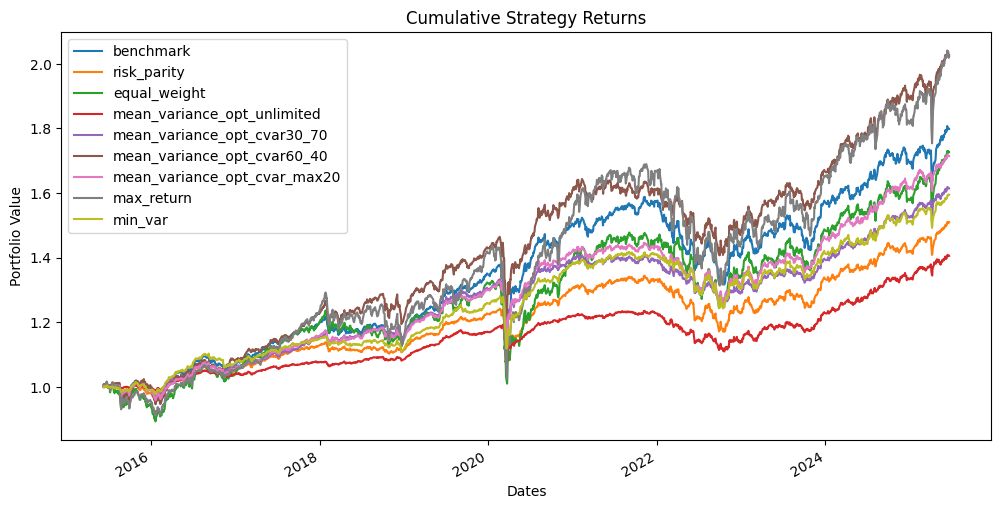

In [84]:

#Graficar los retornos de cada estrategia 
import matplotlib.pyplot as plt

returns_dict = {
    'benchmark': benchmark_results,
    'risk_parity': portfolio_rp_results,
    'equal_weight': portfolio_ew_results,
    'mean_variance_opt_unlimited': portfolio_mvo_results_unlimited,
    'mean_variance_opt_cvar30_70': portfolio_mvo_results_lim_cvar30_70,
    #'mean_variance_opt_cvar40_60': portfolio_mvo_results_lim_cvar40_60,
    'mean_variance_opt_cvar60_40': portfolio_mvo_results_lim_cvar60_40,
    'mean_variance_opt_cvar_max20': portfolio_mvo_results_lim_cvar_max20,
    'max_return': portfolio_maxreturn,
    'min_var': portfolio_min_var
}

def plot_strategy_comparison(returns_dict):
    cumulative_returns = pd.DataFrame({
        strategy: (1 + returns).cumprod() 
        for strategy, returns in returns_dict.items()
    })

    cumulative_returns.plot(figsize=(12, 6))
    plt.title('Cumulative Strategy Returns')
    plt.ylabel('Portfolio Value')
    plt.show()

plot_strategy_comparison(returns_dict)



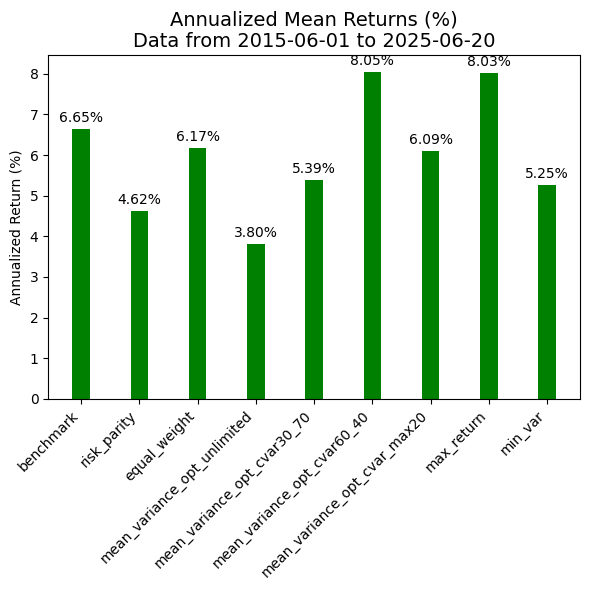

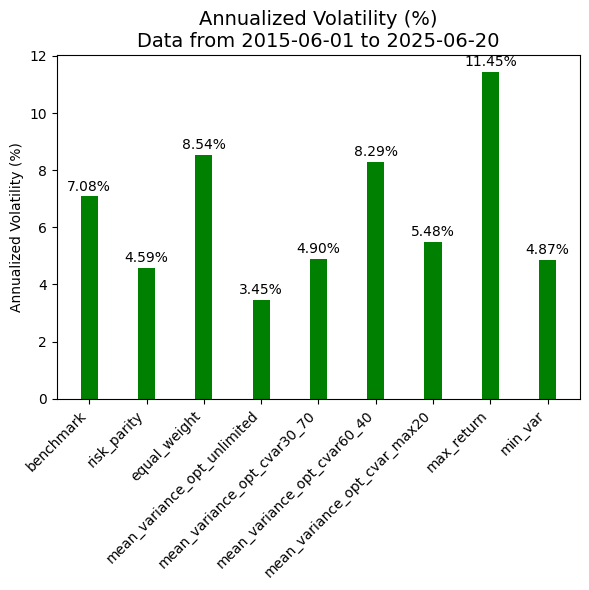

In [89]:
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_annualized_mean_returns(returns_dict):
    annualized_mean_returns_data = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
        annualized_mean_returns_data[strategy] = annualized_return

    annualized_mean_returns = pd.Series(annualized_mean_returns_data)

    conditional_colors = ["green" if value > 0 else "red" for value in annualized_mean_returns]

    fig, ax = plt.subplots(figsize=(6, 6))

    bars = ax.bar(
        annualized_mean_returns.index,
        annualized_mean_returns * 100,  # Convert to percentage
        color=conditional_colors,
        width= 0.3
    );

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10
        );

    start_date = "2015-06-01"
    title_text = f"Annualized Mean Returns (%)\nData from {start_date} to {returns.index[-1].strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=45, ha='right');
    plt.ylabel("Annualized Return (%)");
    plt.tight_layout();
    plt.show()

def plot_annualized_volatility(returns_dict):
    annualized_volatility_data = {}
    for strategy, returns in returns_dict.items():
        annualized_volatility = returns.std() * np.sqrt(252)
        annualized_volatility_data[strategy] = annualized_volatility

    annualized_volatility = pd.Series(annualized_volatility_data)

    conditional_colors = ["green" if value > 0 else "red" for value in annualized_volatility]

    fig, ax = plt.subplots(figsize=(6, 6))

    bars = ax.bar(
        annualized_volatility.index,
        annualized_volatility * 100,  # Convert to percentage
        color=conditional_colors,
        width= 0.3
    );

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10
        );

    start_date = "2015-06-01"
    title_text = f"Annualized Volatility (%)\nData from {start_date} to {returns.index[-1].strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=45, ha='right');
    plt.ylabel("Annualized Volatility (%)");
    plt.tight_layout();
    plt.show()

plot_annualized_mean_returns(returns_dict)
plot_annualized_volatility(returns_dict)

In [86]:
def annualized_sharpe_ratio(returns_dict):
    sharpe_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
        annualized_volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
        sharpe_ratios[strategy] = sharpe_ratio

    return pd.Series(sharpe_ratios)
annualized_sharpe = annualized_sharpe_ratio(returns_dict)
print(f"annualized sharpe ratio by strategy: \n{annualized_sharpe}")

def annualized_sortino_ratio(returns_dict, target_return=0.03):
    sortino_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
        downside_returns = returns[returns < target_return]
        downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = (annualized_return - target_return) / downside_deviation if downside_deviation > 0 else 0
        sortino_ratios[strategy] = sortino_ratio

    return pd.Series(sortino_ratios)
annualized_sortino = annualized_sortino_ratio(returns_dict)
print(f"annualized sortino ratio by strategy: \n{annualized_sortino}")

def annualized_max_drawdown(returns_dict):
    max_drawdowns = {}
    for strategy, returns in returns_dict.items():
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        max_drawdowns[strategy] = max_drawdown

    return pd.Series(max_drawdowns)
annualized_max_dd = annualized_max_drawdown(returns_dict)
print(f"annualized max drawdown by strategy: \n{annualized_max_dd}")

def annualized_calmar_ratio(returns_dict):
    calmar_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
        max_drawdown = annualized_max_drawdown({strategy: returns})[strategy]
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
        calmar_ratios[strategy] = calmar_ratio

    return pd.Series(calmar_ratios)
annualized_calmar = annualized_calmar_ratio(returns_dict)
print(f"annualized calmar ratio by strategy: \n{annualized_calmar}")

strategies_ratios = pd.DataFrame({
    'Annualized Sharpe Ratio': annualized_sharpe,
    'Annualized Sortino Ratio': annualized_sortino,
    'Annualized Max Drawdown': annualized_max_dd,
    'Annualized Calmar Ratio': annualized_calmar
})
strategies_ratios 

annualized sharpe ratio by strategy: 
benchmark                       0.938341
risk_parity                     1.006236
equal_weight                    0.722100
mean_variance_opt_unlimited     1.102202
mean_variance_opt_cvar30_70     1.099559
mean_variance_opt_cvar60_40     0.971693
mean_variance_opt_cvar_max20    1.111161
max_return                      0.701171
min_var                         1.077787
dtype: float64
annualized sortino ratio by strategy: 
benchmark                       0.527540
risk_parity                     0.351802
equal_weight                    0.375725
mean_variance_opt_unlimited     0.232122
mean_variance_opt_cvar30_70     0.486582
mean_variance_opt_cvar60_40     0.633621
mean_variance_opt_cvar_max20    0.562317
max_return                      0.454437
min_var                         0.461315
dtype: float64
annualized max drawdown by strategy: 
benchmark                      -0.182725
risk_parity                    -0.138524
equal_weight                   -0.2

,Annualized Sharpe Ratio,Annualized Sortino Ratio,Annualized Max Drawdown,Annualized Calmar Ratio
benchmark,0.938341,0.527540,-0.182725,0.363731
risk_parity,1.006236,0.351802,-0.138524,0.333310
equal_weight,0.722100,0.375725,-0.239490,0.257621
mean_variance_opt_unlimited,1.102202,0.232122,-0.102066,0.372560
mean_variance_opt_cvar30_70,1.099559,0.486582,-0.118597,0.454534
mean_variance_opt_cvar60_40,0.971693,0.633621,-0.167298,0.481243
mean_variance_opt_cvar_max20,1.111161,0.562317,-0.135915,0.447883
max_return,0.701171,0.454437,-0.286543,0.280097
min_var,1.077787,0.461315,-0.125553,0.418396


<Figure size 1200x600 with 0 Axes>

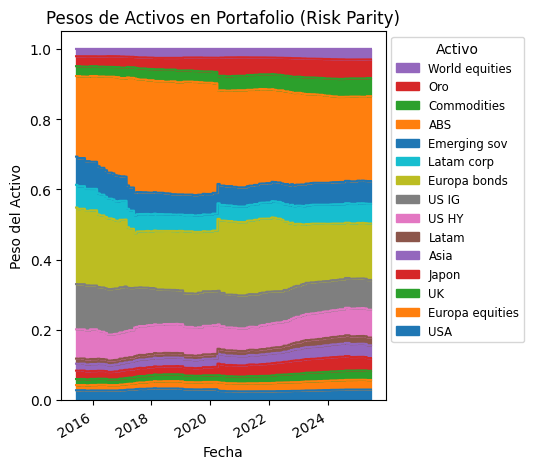

<Figure size 1200x600 with 0 Axes>

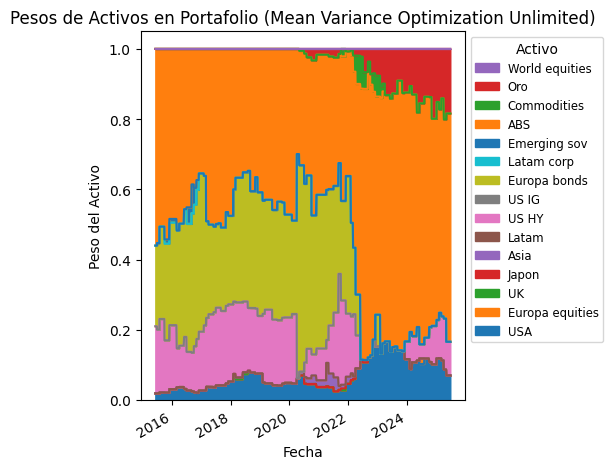

<Figure size 1200x600 with 0 Axes>

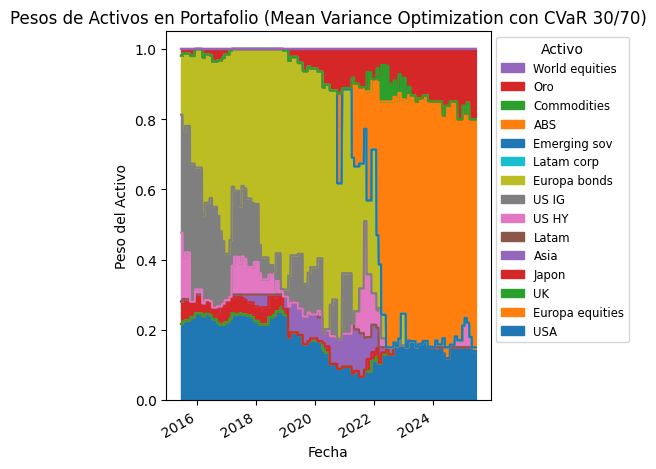

<Figure size 1200x600 with 0 Axes>

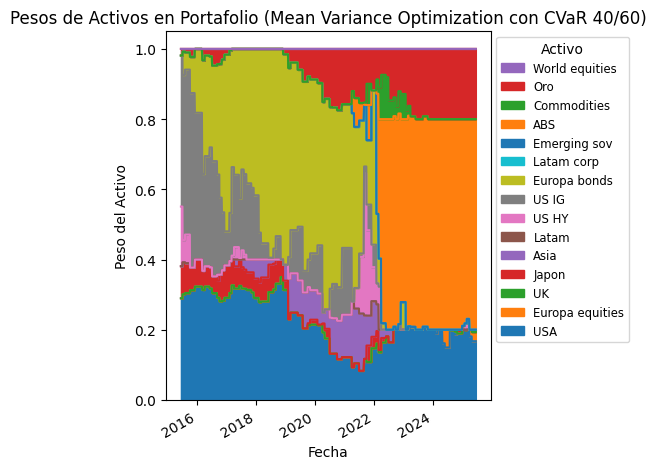

<Figure size 1200x600 with 0 Axes>

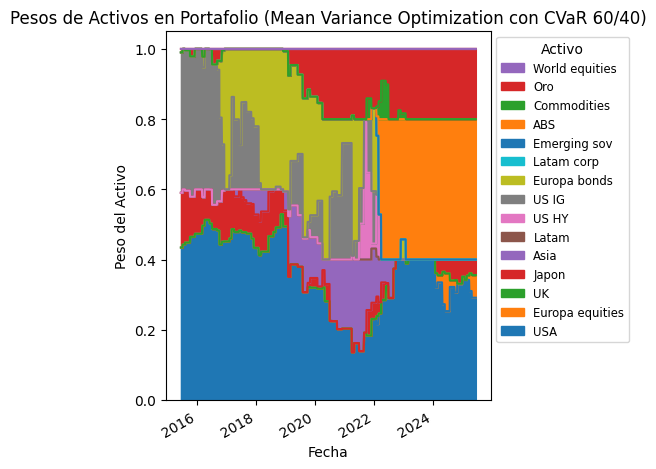

<Figure size 1200x600 with 0 Axes>

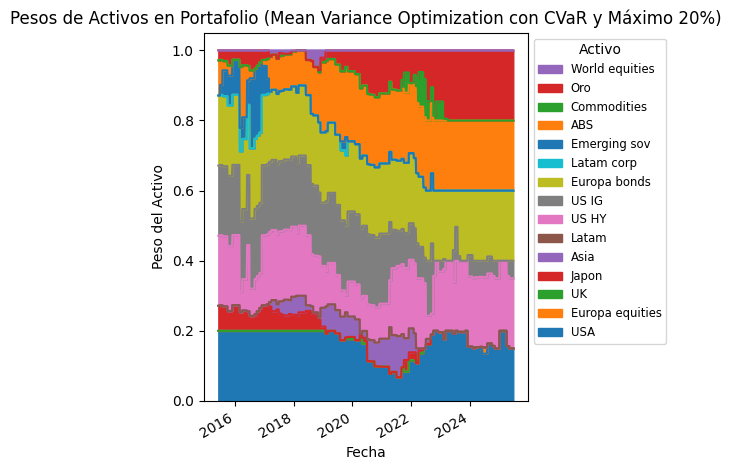

<Figure size 1200x600 with 0 Axes>

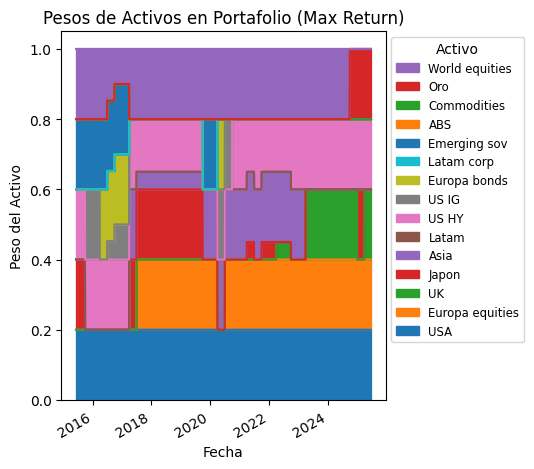

<Figure size 1200x600 with 0 Axes>

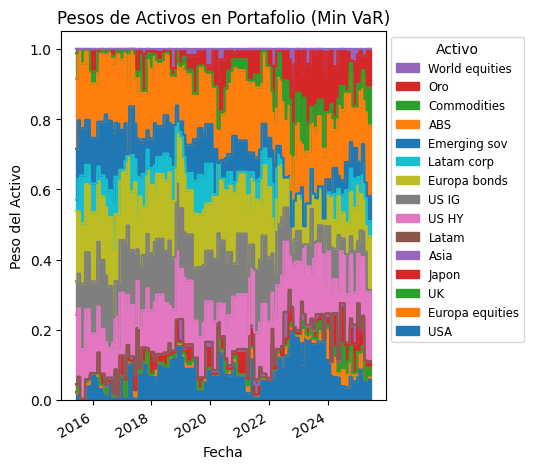

In [90]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que historical_weights_rp y historical_weights_mvo son DataFrames
# donde las columnas son los nombres de los activos y los valores son los pesos --
# en cada fecha.

def plot_stacked_weights(weights_df, title, legend_order=None):
    plt.figure(figsize=(12, 6))
    ax = weights_df.plot.area(stacked=True)
    plt.title(title)
    plt.ylabel('Peso del Activo')
    plt.xlabel('Fecha')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[::-1],  # Invertir el orden de los handles
        labels=labels[::-1],  # Invertir el orden de las etiquetas
        title='Activo',
        loc='upper left',
        bbox_to_anchor=(1, 1),  # Mover la leyenda fuera del gráfico
        fontsize='small',
        ncol=1,  # Número de columnas en la leyenda
        borderaxespad=0.5,  # Espacio entre la leyenda y el gráfico
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar el layout para que no se superponga con la leyenda
    plt.show()

lista_activos = ['USA', 'Europa equities', 'UK', 'Japon', 'Asia', 'Latam', 'US HY', 'US IG', 'Europa bonds', 'Latam corp', 'Emerging sov', 'ABS', 'Commodities', 'Oro']

# Graficar los pesos de la estrategia de Paridad de Riesgo como barras apiladas
plot_stacked_weights(weights_rp, 'Pesos de Activos en Portafolio (Risk Parity)')

# Graficar los pesos de la estrategia de Optimización de Varianza Media como barras apiladas
plot_stacked_weights(weights_mvo_unlimited, 'Pesos de Activos en Portafolio (Mean Variance Optimization Unlimited)', lista_activos)
plot_stacked_weights(weights_mvo_lim_cvar30_70, 'Pesos de Activos en Portafolio (Mean Variance Optimization con CVaR 30/70)', lista_activos)
plot_stacked_weights(weights_mvo_lim_cvar40_60, 'Pesos de Activos en Portafolio (Mean Variance Optimization con CVaR 40/60)', lista_activos)
plot_stacked_weights(weights_mvo_lim_cvar60_40, 'Pesos de Activos en Portafolio (Mean Variance Optimization con CVaR 60/40)', lista_activos)
plot_stacked_weights(weights_mvo_lim_cvar_max20, 'Pesos de Activos en Portafolio (Mean Variance Optimization con CVaR y Máximo 20%)', lista_activos)
plot_stacked_weights(weights_maxreturn, 'Pesos de Activos en Portafolio (Max Return)', lista_activos)
plot_stacked_weights(weights_min_var, 'Pesos de Activos en Portafolio (Min VaR)', lista_activos)
